## Diffusion on MNIST

We will build a diffusion model on simple handwritten images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

### MNIST

The MNIST data set consists of $28 \times 28$ black-and-white images with handwritten digits. We will download the training set and count the number of images in the data set.

In [ ]:
train_data = torchvision.datasets.MNIST('dataset', train=True, download=True, transform=torchvision.transforms.ToTensor())

print(f'There are {len(train_data)} images in the training set!')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

There are 60000 images in the training set!


Since there are 60k images in the training set, we'll need a way to train on *batches* of them. For this purpose, we'll use the pytorch `DataLoader` and specify a batch size of 512 (powers of two with helps with parallelization).

In [ ]:
batch_size = 512 

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

Before we begin building the architecture, let's take a look at the images in the data set.

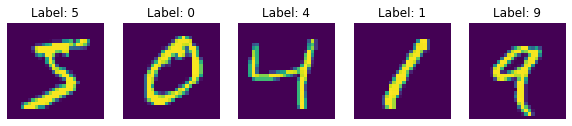

In [ ]:
images, labels = next(iter(train_loader)) # load from the dataloader

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.axis('off')
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze().numpy())

As promised, we have handwritten digits that resemble numbers. As a sanity check, what is the shape of `images` as defined above?

In [ ]:
# Check that the shape of images makes sense.
# (batch_size, 1, 28, 28)
images.shape

torch.Size([512, 1, 28, 28])

The first step of diffusion is to generate the training data. We'll draw the random noise from the normal distribution. However, we'll have to choose the standard deviation of the noise and how many steps of noise to apply. In order to choose appropriate values, let's plot what the noising process does.

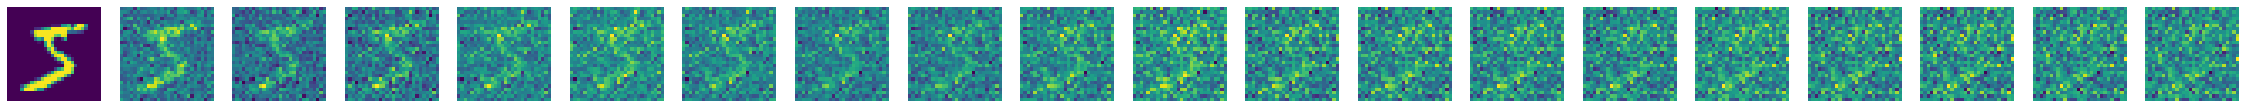

In [ ]:
images, labels = next(iter(train_loader))
noisy_images = images

# The two hyperparameters we are choosing.
sigma = .35 # standard deviation
noise_steps = 20 # number of steps we apply noise

plt.figure(figsize=(noise_steps * 2, 10))
for i in range(noise_steps):
  # Draw noise from a normal distribution with standard deviation sigma.
  noise = torch.normal(0, sigma, images.shape) 
  plt.subplot(1,noise_steps,i+1)
  plt.imshow(noisy_images[0].squeeze())
  plt.axis('off')
  # Add the noise to the image.
  noisy_images = noise + noisy_images

After playing with the hyperparemeters, I set `sigma`=.35 and `noise_steps`=20. I chose these values with the following considerations in mind:

* Since the diffusion process will begin with noise, it's important that the training data includes noisy images that look like noise (i.e. no indication of the starting image).

* Simultaneously, there should be lots of images where the starting image is somewhat apparent. In this way, we train the model to remove noise both on images that look like noise *and* images that somewhat resemble the underlying image.

### Architecture

Let's begin by defining the normalization function. We're simplying going to subtract the mean, divide by the standard deviation, and multiply by `sigma`. However, because we are applying this operation to each image separately in a batch, we need to be slightly careful about the dimensions.

In [ ]:
def normalize(x, sigma):
  # x is (batch_size, 28*28)
  mean = x.mean(dim=-1).view(-1, 1)
  # mean is (batch_size, 1) i.e. a different mean for each image
  std = x.std(dim=-1).view(-1,1)
  # std is (batch_size, 1) i.e. a different standard deviation for each image
  return (x-mean) / std * sigma

We're now ready to define the diffusion architecture. Note that we will pass in they hyperparameters `sigma` and `noise_steps` when we initialize the model. In addition, we will actually use a very simple two layer linear architecture. There will be about $(28 \cdot 28)^2 = 614656$ parameters which, since the images are small, is relatively mangeable. When we pass them in, we will one-hot the amount of noise and the number of labels.

In [ ]:
class Diffuser(nn.Module):
  def __init__(self, sigma, noise_steps):
    super(Diffuser, self).__init__()
    # Recall the input is the image,
    # the amount of noise applied (this will be one-hot encoded),
    # and the number of labels (this will also be one-hot encoded).
    self.layers = nn.Sequential(
      nn.Linear(28*28+noise_steps+10, 28*28),
      nn.ReLU(),
      nn.Linear(28*28, 28*28)
    )
    self.sigma = sigma
    self.noise_steps = noise_steps
 
  def forward(self, images, noise_level, labels):
    # Convert image from (batch_size, 1, 28, 28) to (batch_size, 28*28) using .view
    images = images.view(-1, 28*28)
    # Combine the image with the noise level and labels.
    # We one hot encode both using F.one_hot
    noise_level_encoding = F.one_hot(
        torch.tensor([noise_level]*images.shape[0]), num_classes = self.noise_steps
    ).to(device)
    labels_encoding = F.one_hot(labels, num_classes = 10).to(device)
    # Concatenate the three inputs in a batch of long vectors    
    x = torch.cat((images, noise_level_encoding, labels_encoding), 1)
    # The shape should now be (batch_size, 28*28+noise_steps+10) 
    # Feed the input through the layers.
    x = self.layers(x)
    # Normalize x using our normalize function
    x = normalize(x, self.sigma)
    # Reformat the output so it is (batch_size, 1, 28, 28) using .view
    x = x.view(-1, 1, 28, 28)
    return x

Now we are ready to initialize the model, optimizer, and criterion. So that we can train faster on the GPU, we will also define the device. To use the GPU on colab, make sure that Runtime > Change runtime type > Hardware accelerator is on GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Diffuser(sigma, noise_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1)
criterion = nn.MSELoss()

We'll also want to sample noise efficiently on the GPU. To do this, we'll define a normal distribution with standard deviation `sigma`.

In [ ]:
# Define unit_normal as an instance of torch.distributions.Normal
# and put its parameters (loc and scale) on the device.
unit_normal = torch.distributions.Normal(0, sigma)
unit_normal.loc = unit_normal.loc.to(device)
unit_normal.scale = unit_normal.scale.to(device)

So that we can visualize how the model is doing during training, let's write an evaluation function. The function will sample random noise and, guided by each label, use the model to repeatedly remove noise from the image for `noise_steps` iterations.

The initial noise will be sampled from a mean-centered normal distribution with standard deviation `sigma` `noise_steps`^1/2. (This is because of a [special property](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#:~:text=This%20means%20that%20the%20sum,squares%20of%20the%20standard%20deviations) of the sum of normal distributions.)

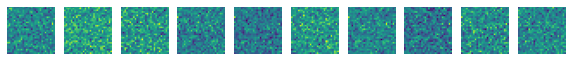

In [ ]:
def evaluate(model, noise_steps):
  # Sample noisy images.
  noisy_images = unit_normal.sample((10,1,28,28))*np.sqrt(noise_steps)
  # Initialize labels.
  labels = torch.tensor([i for i in range(10)])
  plt.figure(figsize=(10, 5))
  # Remove noise from the images.
  for noise_step in range(noise_steps):    
    # Why is noise level defined as below?
    noise_level = noise_steps - noise_step - 1
    # Apply the model without keeping track of gradient.
    with torch.no_grad():
      noise = model(noisy_images, noise_level, labels)
    noisy_images -= noise
  # Plot the resulting images.
  for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(noisy_images[i].cpu().squeeze())
    plt.axis('off')
  plt.show()

evaluate(model, noise_steps)

As we expect, the untrained model just produces noise. Let's see if we can do any better after training.

### Training

We will now train the model! For each batch in each epoch, we will try different noise levels in a random order (this is to randomize the gradient descent updates). Using the variance trick for normal distributions, we can sample a noisy image after `noise_level` steps of `sigma` noise simply by sampling from a distribution with standard deviation `sigma` `noise_level`^1/2.

Epoch: 0 	 Loss: 447.25660448893905


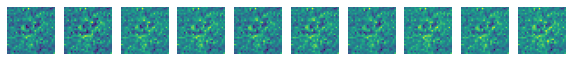

Epoch: 1 	 Loss: 394.45550898462534


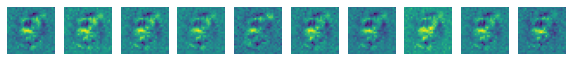

Epoch: 2 	 Loss: 386.4467215165496


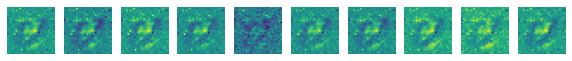

Epoch: 3 	 Loss: 383.4124325532466


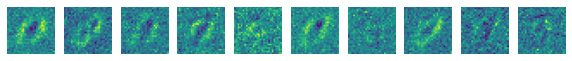

Epoch: 4 	 Loss: 381.23594390042126


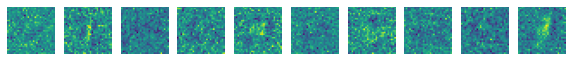

Epoch: 5 	 Loss: 379.2635171096772


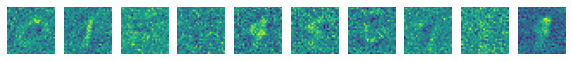

Epoch: 6 	 Loss: 377.1577216684818


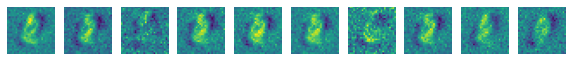

Epoch: 7 	 Loss: 376.24848429486156


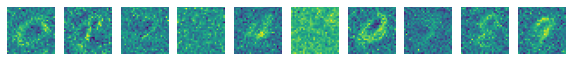

Epoch: 8 	 Loss: 375.87277957610786


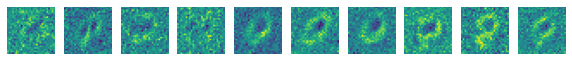

Epoch: 9 	 Loss: 374.94414722919464


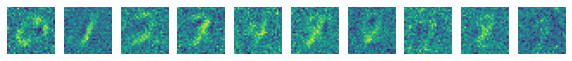

Epoch: 10 	 Loss: 374.4237868450582


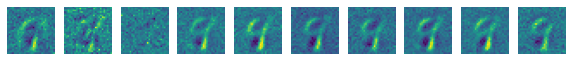

Epoch: 11 	 Loss: 374.03960914723575


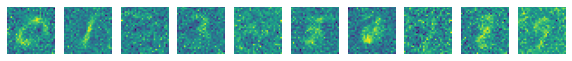

Epoch: 12 	 Loss: 373.1436390336603


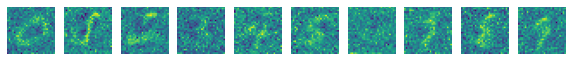

Epoch: 13 	 Loss: 373.28030573762953


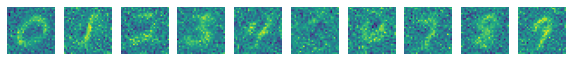

Epoch: 14 	 Loss: 372.30501700378954


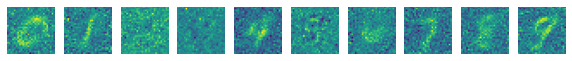

Epoch: 15 	 Loss: 372.2443254031241


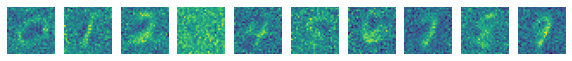

Epoch: 16 	 Loss: 372.31927990168333


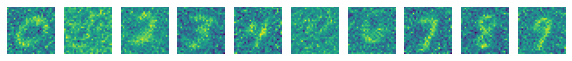

Epoch: 17 	 Loss: 371.8964126743376


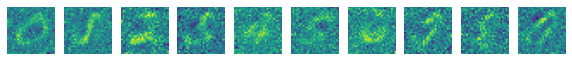

Epoch: 18 	 Loss: 371.53993342630565


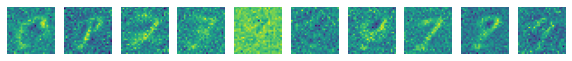

Epoch: 19 	 Loss: 371.15931715629995


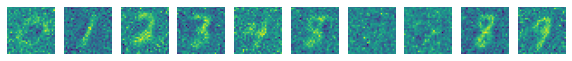

Epoch: 20 	 Loss: 371.4310539383441


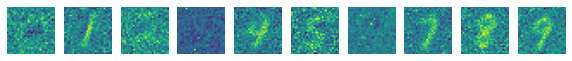

Epoch: 21 	 Loss: 371.3271104581654


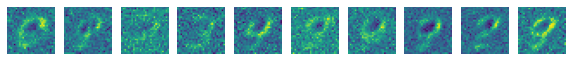

Epoch: 22 	 Loss: 370.31047406233847


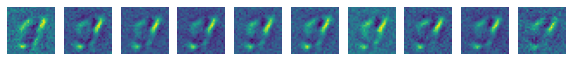

Epoch: 23 	 Loss: 370.8057657536119


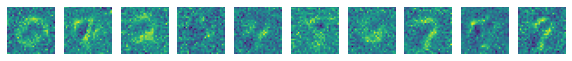

Epoch: 24 	 Loss: 370.4066873360425


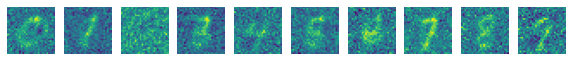

In [ ]:
num_epochs = 25
for epoch in range(num_epochs):
  epoch_loss = 0
  for images, labels in train_loader:
    # Put the images on the device.
    images = images.to(device)
    for noise_level in torch.randperm(noise_steps):
      # Build the less noisy image using the variance trick for normal distributions.
      less_noisy = images + unit_normal.sample(images.shape) * np.sqrt(noise_level)
      # Generate one more step of noise (standard deviation sigma).
      one_step_noise = unit_normal.sample(images.shape)
      # Generate the next noisy image.
      more_noisy = less_noisy + one_step_noise 
      # Use the model to predict the noise using more_noisy, noise_level, and labels.
      output = model(more_noisy, noise_level, labels)
      # Compute the loss and update.
      # The loss is simply the mean squared difference.
      loss = criterion(output, one_step_noise)
      # Zero the gradient of the optimizer.
      optimizer.zero_grad()
      # Backpropagate.
      loss.backward()
      # And take a step :)
      optimizer.step() 

      epoch_loss += loss.item()
  # We will print out the loss for each epoch.
  print(f'Epoch: {epoch} \t Loss: {epoch_loss}')
  # And call our evaluate function to see any progress.
  evaluate(model, noise_steps)

We may have to squint but, if we the training worked successfully, we can see generated images with each digit! This is pretty impressive for 7 minutes of training on a free GPU.

Of course, you may want to see what some more powerful models can accomplish. The second part of this lab uses a pretrained model for stable diffusion.

References: 
https://chinmayhegde.github.io/dl-notes/